In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import pytensor
from pytensor.tensor.optimize import minimize
from pymc_extras.inference.inla import *

from pymc.model.fgraph import fgraph_from_model, model_from_fgraph
from pymc_extras.model.marginal.marginal_model import marginalize

In [3]:
from pytensor.gradient import grad, hessian, jacobian
from pytensor.tensor.optimize import root

x = pt.vector("x")
var = pt.stack([x])
y = pt.stack([var[0], var[0] ** 2])
sol, _ = root(y, variables=var)
jacobian(sol, var, vectorize=True)

ExpandDims{axis=0}.0
(1, None)
(1, None, 1)


Reshape{4}.0

In [4]:
rng = np.random.default_rng(12345)
n = 10000
d = 10

# Initialise arrays
mu_true = rng.random(d)
cov_true = np.diag(rng.random(d))
Q_val = np.diag(rng.random(d))
cov_param_val = np.diag(rng.random(d))

x_val = rng.random(d)
mu_val = rng.random(d)

mu_mu = rng.random(d)
mu_cov = np.diag(np.ones(d))
cov_mu = rng.random(d**2)
cov_cov = np.diag(np.ones(d**2))
Q_mu = rng.random(d**2)
Q_cov = np.diag(np.ones(d**2))

with pm.Model() as model:
    y_obs = rng.multivariate_normal(mean=mu_true, cov=cov_true, size=n)

    mu_param = pm.MvNormal("mu_param", mu=mu_mu, cov=mu_cov)
    # cov_param = np.abs(pm.MvNormal("cov_param", mu=cov_mu, cov=cov_cov))
    # Q = pm.MvNormal("Q", mu=Q_mu, cov=Q_cov)

    x = pm.MvNormal("x", mu=mu_param, tau=Q_val)

    y = pm.MvNormal(
        "y",
        mu=x,
        cov=cov_param_val,  # cov_param.reshape((d, d)),
        observed=y_obs,
    )

    # x0, log_likelihood = get_log_marginal_likelihood(
    #     x=model.rvs_to_values[x],
    #     Q=Q_val,#Q.reshape((d, d)),
    #     mu=mu_param,
    #     optimizer_kwargs={"tol": 1e-8},
    # )

    # args = model.continuous_value_vars + model.discrete_value_vars
    # for i, rv in enumerate(args):
    #     if rv == model.rvs_to_values[x]:
    #         args.pop(i)
    # log_likelihood = pytensor.graph.replace.graph_replace(log_likelihood, {model.rvs_to_values[x]: rng.random(d)})
    # log_laplace_approx = pytensor.function(args, log_likelihood)

    # pm.sample()

ModelFreeRV{transform=None} [id A] 'mu_param' 3
 ├─ MvNormalRV{name='multivariate_normal', signature='(n),(n,n)->(n)', dtype='float64', inplace=False, method='cholesky'}.1 [id B] 'mu_param' 2
 │  ├─ RNG(<Generator(PCG64) at 0x7F8B06F4FD80>) [id C]
 │  ├─ NoneConst{None} [id D]
 │  ├─ Second [id E] 1
 │  │  ├─ Subtensor{:, i} [id F] 0
 │  │  │  ├─ [[1. 0. 0. ... 0. 0. 1.]] [id G]
 │  │  │  └─ -1 [id H]
 │  │  └─ [0.2552323 ... .18013059] [id I]
 │  └─ [[1. 0. 0. ... 0. 0. 1.]] [id G]
 └─ mu_param [id J]
ModelFreeRV{transform=None} [id K] 'x' 8
 ├─ MvNormalRV{name='multivariate_normal', signature='(n),(n,n)->(n)', dtype='float64', inplace=False, method='cholesky'}.1 [id L] 'x' 7
 │  ├─ RNG(<Generator(PCG64) at 0x7F8B06F4C200>) [id M]
 │  ├─ NoneConst{None} [id D]
 │  ├─ Second [id N] 6
 │  │  ├─ Subtensor{:, i} [id O] 5
 │  │  │  ├─ Blockwise{MatrixInverse, (m,m)->(m,m)} [id P] 4
 │  │  │  │  └─ [[0.081594 ... 59856801]] [id Q]
 │  │  │  └─ -1 [id R]
 │  │  └─ ModelFreeRV{transform=None}

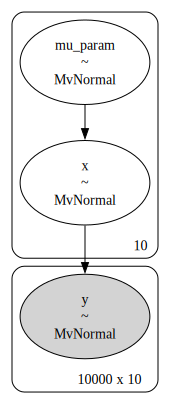

In [5]:
rvs_to_marginalize = [x]

fg, memo = fgraph_from_model(model)
fg.dprint()
rvs_to_marginalize = [memo[rv] for rv in rvs_to_marginalize]
toposort = fg.toposort()

# fg.dprint()
# print(rvs_to_marginalize)
# print(toposort)

from pymc.model.fgraph import (
    ModelFreeRV,
    ModelValuedVar,
)

from pymc_extras.model.marginal.graph_analysis import (
    find_conditional_dependent_rvs,
    find_conditional_input_rvs,
    is_conditional_dependent,
    subgraph_batch_dim_connection,
)

from pymc_extras.model.marginal.marginal_model import (
    _unique,
    collect_shared_vars,
    remove_model_vars,
)

from pymc_extras.model.marginal.distributions import (
    MarginalLaplaceRV,
)

from pymc.pytensorf import collect_default_updates

from pytensor.graph import (
    FunctionGraph,
    Variable,
    clone_replace,
)

for rv_to_marginalize in sorted(
    rvs_to_marginalize,
    key=lambda rv: toposort.index(rv.owner),
    reverse=True,
):
    all_rvs = [node.out for node in fg.toposort() if isinstance(node.op, ModelValuedVar)]

    dependent_rvs = find_conditional_dependent_rvs(rv_to_marginalize, all_rvs)
    if not dependent_rvs:
        # TODO: This should at most be a warning, not an error
        raise ValueError(f"No RVs depend on marginalized RV {rv_to_marginalize}")

    # Issue warning for IntervalTransform on dependent RVs
    for dependent_rv in dependent_rvs:
        transform = dependent_rv.owner.op.transform

        # if isinstance(transform, IntervalTransform) or (
        #     isinstance(transform, Chain)
        #     and any(isinstance(tr, IntervalTransform) for tr in transform.transform_list)
        # ):
        #     warnings.warn(
        #         f"The transform {transform} for the variable {dependent_rv}, which depends on the "
        #         f"marginalized {rv_to_marginalize} may no longer work if bounds depended on other variables.",
        #         UserWarning,
        #     )

    # Check that no deterministics or potentials depend on the rv to marginalize
    for det in model.deterministics:
        if is_conditional_dependent(memo[det], rv_to_marginalize, all_rvs):
            raise NotImplementedError(
                f"Cannot marginalize {rv_to_marginalize} due to dependent Deterministic {det}"
            )
    for pot in model.potentials:
        if is_conditional_dependent(memo[pot], rv_to_marginalize, all_rvs):
            raise NotImplementedError(
                f"Cannot marginalize {rv_to_marginalize} due to dependent Potential {pot}"
            )

    marginalized_rv_input_rvs = find_conditional_input_rvs([rv_to_marginalize], all_rvs)
    other_direct_rv_ancestors = [
        rv
        for rv in find_conditional_input_rvs(dependent_rvs, all_rvs)
        if rv is not rv_to_marginalize
    ]
    input_rvs = _unique((*marginalized_rv_input_rvs, *other_direct_rv_ancestors))

pm.model_to_graphviz(model)

[mu_param, RNG(<Generator(PCG64) at 0x7F8B06F4C580>), RNG(<Generator(PCG64) at 0x7F8B06F4C200>)]
[x, y, MvNormalRV{name='multivariate_normal', signature='(n),(n,n)->(n)', dtype='float64', inplace=False, method='cholesky'}.0, MvNormalRV{name='multivariate_normal', signature='(n),(n,n)->(n)', dtype='float64', inplace=False, method='cholesky'}.0]
[mu_param, RNG(<Generator(PCG64) at 0x7F8B06F4C580>), RNG(<Generator(PCG64) at 0x7F8B06F4C200>)]
[x, y, MvNormalRV{name='multivariate_normal', signature='(n),(n,n)->(n)', dtype='float64', inplace=False, method='cholesky'}.0, MvNormalRV{name='multivariate_normal', signature='(n),(n,n)->(n)', dtype='float64', inplace=False, method='cholesky'}.0]
[x, y, MarginalLaplaceRV{inline=False}.2, MarginalLaplaceRV{inline=False}.3]
ModelFreeRV{transform=None} [id A] 'mu_param' 3
 ├─ MvNormalRV{name='multivariate_normal', signature='(n),(n,n)->(n)', dtype='float64', inplace=False, method='cholesky'}.1 [id B] 'mu_param' 2
 │  ├─ RNG(<Generator(PCG64) at 0x7F8B0

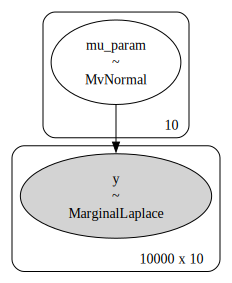

In [6]:
output_rvs = [rv_to_marginalize, *dependent_rvs]
rng_updates = collect_default_updates(output_rvs, inputs=input_rvs, must_be_shared=False)
outputs = output_rvs + list(rng_updates.values())
inputs = input_rvs + list(rng_updates.keys())
# Add any other shared variable inputs
inputs += collect_shared_vars(output_rvs, blockers=inputs)

inner_inputs = [inp.clone() for inp in inputs]
inner_outputs = clone_replace(outputs, replace=dict(zip(inputs, inner_inputs)))
inner_outputs = remove_model_vars(inner_outputs)

marginalize_constructor = MarginalLaplaceRV

_, _, *dims = rv_to_marginalize.owner.inputs
marginalization_op = marginalize_constructor(
    inputs=inner_inputs,
    outputs=inner_outputs,
    dims_connections=[
        (None,),
    ],  # dependent_rvs_dim_connections, # TODO NOT SURE WHAT THIS IS
    dims=dims,
    # x0=x0,
    # marginalized_rv_input_rvs=marginalized_rv_input_rvs
)

new_outputs = marginalization_op(*inputs)
for old_output, new_output in zip(outputs, new_outputs):
    new_output.name = old_output.name

model_replacements = []
for old_output, new_output in zip(outputs, new_outputs):
    if old_output is rv_to_marginalize or not isinstance(old_output.owner.op, ModelValuedVar):
        # Replace the marginalized ModelFreeRV (or non model-variables) themselves
        var_to_replace = old_output
    else:
        # Replace the underlying RV, keeping the same value, transform and dims
        var_to_replace = old_output.owner.inputs[0]
    model_replacements.append((var_to_replace, new_output))

print(inner_inputs)
print(inner_outputs)
print(inputs)

print(outputs)
print(new_outputs)

fg.replace_all(model_replacements)
fg.dprint()

model_marg = model_from_fgraph(fg, mutate_fgraph=True)
pm.model_to_graphviz(model_marg)

In [93]:
from pytensor.tensor.optimize import root

A = pt.matrix("A", shape=(3, 3))
x = np.ones((3, 1))
b = pt.vector("b", shape=(3,))

eqns = pt.stack([A @ x - b])
var = pt.stack([A, b])

soln, _ = root(eqns, variables=var)

TypeError: Only tensors with the same number of dimensions can be joined. Input ndims were: [3, 2]

In [21]:
from pytensor.tensor.math import tensordot

a = pt.tensor("a", shape=(10,))
b = pt.tensor("b", shape=(10, 1, 1))

print(a.type.shape)
print(b.type.shape)
# print(b.T.type.shape)

tensordot(a, b, axes=0)

(10,)
(10, 1, 1)


Reshape{4}.0

In [31]:
with model_marg as m:
    pm.sample()

<class 'pytensor.tensor.variable.TensorConstant'>


AttributeError: 'MarginalLaplaceRV' object has no attribute 'owner'

In [ ]:
[2, 2, 3, 4, 2, 2, 2, 3, 3, 4]

In [40]:
rng = np.random.default_rng(12345)
n = 10000
d = 3

# Initialise arrays
mu_true = rng.random(d)
cov_true = np.diag(rng.random(d))
Q_val = np.diag(rng.random(d))
cov_param_val = np.diag(rng.random(d))

x_val = rng.random(d)
mu_val = rng.random(d)

mu_mu = rng.random(d)
mu_cov = np.diag(np.ones(d))
cov_mu = rng.random(d**2)
cov_cov = np.diag(np.ones(d**2))
Q_mu = rng.random(d**2)
Q_cov = np.diag(np.ones(d**2))

with pm.Model() as model:
    y_obs = rng.multivariate_normal(mean=mu_true, cov=cov_true, size=n)

    mu_param = pm.MvNormal("mu_param", mu=mu_mu, cov=mu_cov)
    # cov_param = np.abs(pm.MvNormal("cov_param", mu=cov_mu, cov=cov_cov))
    # Q = pm.MvNormal("Q", mu=Q_mu, cov=Q_cov)

    x = pm.MvNormal("x", mu=mu_param, tau=Q_val)

    y = pm.MvNormal(
        "y",
        mu=x,
        cov=cov_param_val,  # cov_param.reshape((d, d)),
        observed=y_obs,
    )

    # model.logp().dprint()

    # x0, log_likelihood = get_log_marginal_likelihood(
    #     x=model.rvs_to_values[x],
    #     Q=Q_val,#Q.reshape((d, d)),
    #     mu=mu_param,
    #     optimizer_kwargs={"tol": 1e-8},
    # )

    # print(model.free_RVs)

    # # with pm.Model() as inla_model:
    # log_prior = pm.logp(mu_param, mu_mu)
    # log_posterior = log_likelihood + log_prior
    # # # log_posterior.dprint()
    # # # log_posterior = pytensor.graph.replace.graph_replace(log_posterior, {model.rvs_to_values[x]: x0})
    # # # log_posterior_model = model_from_fgraph(log_posterior, mutate_fgraph=True)
    # # idata = pm.sample()
    # # draws = pm.draw(mu_param)
    # idata = pm.sample_prior_predictive()
    # print(idata.prior)
    # print(draws)

    # print(inla_model.free_RVs)
    # log_posterior.dprint()
    # pytensor.graph.fg.FunctionGraph(inputs=[model.rvs_to_values[mu_param], model.rvs_to_values[x]], outputs=[log_posterior])

# inla_model = marginalize(model, [mu_param, cov_param])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_param, Q, x]


Output()

ValueError: Not enough samples to build a trace.

True dataset:

$y \sim N(\mu_{true}, \Sigma_{true})$

Model:

$y|x, \sigma \sim N(Ax, \sigma W)$

Let $A=I$, $W=I$:

$y|x, \sigma \sim N(x, \sigma)$

Comparing model and true data:

$x = \mu_{true}$

$x|\theta \sim N(\mu, Q^{-1})$

$\theta = (\mu, \Sigma_b, \sigma)$

Set $Q = I$ for now.

$\theta = (\mu, \sigma)$

In [27]:
!python -m pytest -v /home/michaln/Michal_Linux/git/GSoC/pymc-extras/tests/test_inla.py

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "/home/michaln/Michal_Linux/git/GSoC/pymc-extras/.pixi/envs/default/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/home/michaln/Michal_Linux/git/GSoC/pymc-extras/.pixi/envs/default/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/michaln/Michal_Linux/git/GSoC/pymc-extras/.pixi/envs/default/lib/python3.12/importlib/__init__.py", line 130, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


============================= test session starts ==============================
platform linux -- Python 3.12.10, pytest-8.4.1, pluggy-1.6.0 -- /home/michaln/Michal_Linux/git/GSoC/pymc-extras/.pixi/envs/default/bin/python
cachedir: .pytest_cache
rootdir: /home/michaln/Michal_Linux/git/GSoC/pymc-extras
configfile: pyproject.toml
plugins: anyio-4.9.0
collected 1 item                                                               

../tests/test_inla.py::test_get_conditional_gaussian_approximation PASSED [100%]

============================== 1 passed in 5.99s ===============================
